# removing the background

See https://flothesof.github.io/removing-background-scikit-image.html for one example. I go through other methods before setting on something.

In [1]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform, feature, color, draw

In [2]:
url = "https://storage.googleapis.com/acmiyaguchi/pinecube/captures/202109050700.jpeg"
img = skio.imread(url)

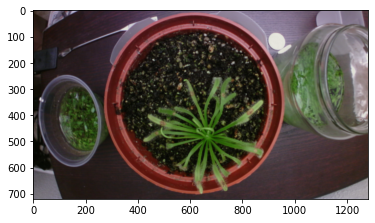

In [3]:
plt.imshow(img)

## hough transform

https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html

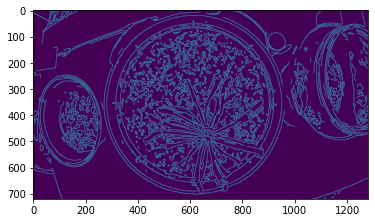

In [4]:
edges = feature.canny(color.rgb2gray(img))
plt.imshow(edges)

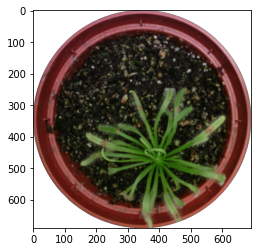

In [5]:
def crop_circle(img, inner_radius=340, outer_radius=350):
    edges = feature.canny(color.rgb2gray(img))
    
    # inner pot is around r=302, inner lid is around r=334, outerlid is r=344
    hough_radii = np.arange(inner_radius, outer_radius, 1)
    hough_res = transform.hough_circle(edges, hough_radii)
    accums, cx, cy, radii = transform.hough_circle_peaks(
        hough_res,
        hough_radii,
        total_num_peaks=1
    )
    
    image = np.dstack((img, np.ones(img.shape[:2]).astype(np.uint8)*255))
    mask = np.zeros(image.shape, dtype=bool)
    cyy, cxx, rr = list(zip(cy, cx, radii))[0]
    mask[draw.disk((cyy, cxx), rr, shape=image.shape)] = 1
    
    return (image*mask)[cyy-rr:cyy+rr, cxx-rr:cxx+rr]
    
res = crop_circle(img)
plt.imshow(res)
plt.show()

In [6]:
skio.imsave("01-cropped-plant.png", res)

## appendix

Crop the image and try various segmentation methods.

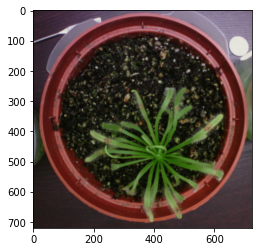

In [7]:
cropped = img[:, 250:975]
plt.imshow(cropped)

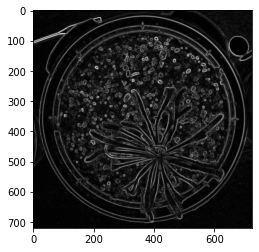

In [8]:
from skimage import filters, color

gray_crop = color.rgb2gray(cropped)
sobel = filters.sobel(gray_crop)
plt.imshow(sobel, cmap="gray")

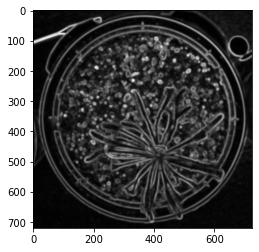

In [9]:
blurred = filters.gaussian(sobel, sigma=2.0)
plt.imshow(blurred, cmap="gray")

In [10]:
seed_mask = np.zeros(blurred.shape, dtype=int)
seed_mask[0, 0] = 1 # background
seed_mask[400, 400] = 2 # foreground

(0.0, 1280.0, 720.0, 0.0)

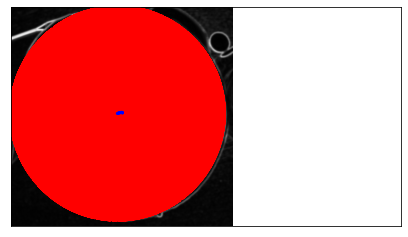

In [11]:
from skimage import segmentation
from skimage import draw
rr, cc = draw.circle_perimeter(350, 350, 350)
init = np.array([rr, cc]).T
snake = segmentation.active_contour(blurred, init)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(blurred, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

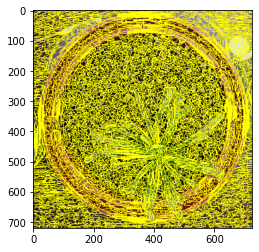

In [12]:
segments = segmentation.felzenszwalb(cropped, scale=3)
plt.imshow(segmentation.mark_boundaries(cropped, segments))

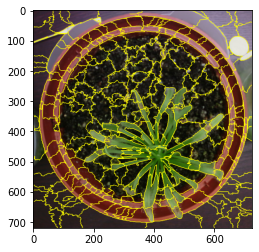

In [13]:
segments = segmentation.quickshift(cropped, kernel_size=10, max_dist=10, ratio=0.8)
plt.imshow(segmentation.mark_boundaries(cropped, segments))